In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets

# Load basic science tools
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from numpy.random import rand, randint, uniform, choice, normal 
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [9]:
import plotly.express as px
from numba import jit, njit

### Write main helper function of Molecular dynamics
 
 0. Initialize system (num particles, potentials, box size)
 <br><br>
 1. Set sim parameters (temperature,  thermostat, integration time step, num steps) 
 <br><br>
 2. Evolve velocities by computing forces (via a Verlet Algorithm)
 <br><br>
 3. Enforce PBC, update velocities, positions, observables. 
 <br><br>
 5. repeat 2-3 until target timesteps reached

### Specify initial configuration of the system

In [285]:
#-------Simulation parameters ----
N        = 100      # Try different values
rho      = 0.85     # We set density 
T  = 2
L  =  (N/rho)**(1/3) # Length of the box side

print('Num particles: ', N, '\nBox Length:    ', L)

Num particles:  100 
Box Length:     4.899973050296446


### Initialize positions and velocities

In [208]:
def initialize(N, L):
    
    """Put N particles in a box, 
    using dense packing unit lattice of size n3"""

    pos = np.zeros((N,3))
     
    n3 = int(N **(1/3)) + 1
    iix = iiy = iiz = 0
    
    for i in range(N):
        
        pos[i][0] = (iix + 0.5) * L / n3
        pos[i][1] = (iiy + 0.5) * L / n3
        pos[i][2] = (iiz + 0.5) * L / n3
        
        iix += 1
        
        if iix == n3:
            
            iix  = 0
            iiy += 1
            
            if iiy == n3:
                
                iiy = 0
                iiz += 1 

    # Draw velocities from normal distribution
    vel = np.random.randn(N, 3)
                
    return pos -L/2 , vel - np.mean(vel)

### Visualize lattice and velocities

In [209]:
pos, vel = initialize(N, L)

#px.scatter_3d(x=pos[:,0], y=pos[:,1], z=pos[:,2], opacity=0.5)

### Functions for distances and PBC

In [345]:
@jit
def pbc_wrap(pp, L):
    
    ''' (a) if pp = (x,y,z) position; wraps it back to box (with origin in the center!) 
        (b) if pp = (dr_x, dr_y, dr_z) distances; uses nearest image convension'''
    
    #Using fancy indexing to select points outside of box        
    pp[pp  > L/2]  -= L  
    pp[pp  < -L/2] += L
    
    return pp

### Compute forces, potential energy and pressure

In [357]:
@njit
def force_update(pos, L, sig, eps, trunc):
    
    """Calculate the forces 
    alsoassociated potential energy and pressure"""
    N=len(pos)
    
    force = np.zeros((N,N,3))   # Force matrix vector
    pe    = 0.0

    for i in range(N-1):
        for j in range(i+1, N):

            dr  = pbc_wrap(pos[i]-pos[j], L)
            
            dr2 = np.sum(dr**2)
            
            if  dr2 < trunc**2:   
                
                pe    += 4*eps * ( (sig/dr2)**6 - (sig/dr2)**3 )
                
                force[i,j] += -eps  * 48 * ( sig**12 / dr2**7 - 0.5 *sig**6 / dr2**4) * dr
                force[j,i] += -force[i,j] 
                
    press = np.sum(force * dr)
         
    return force,  pe, press

### Update positions via Verlet algorithm

In [358]:
@njit
def md_update(pos, L, vel, force, dt):
    
    """Verloctiy verlet algorithm for 
    updating positions and velocites over time-step dt"""

    # Convert (N,N,3) force matrix to force acting per particle (N,3) 
    F = np.sum(force, axis=0) - np.sum(force, axis=1)
           
    pos += vel * dt + 0.5* F * dt*dt
    
    vel += 0.5 * F * dt
    
    return pos, vel

### Thermostats to keep T=const

In [359]:
@jit
def therm_simple(vel, T, N):
    
    """Simple thermostat
    Returns new updated velocty and previous kinetic energy and temperature 
    """
    
    KE = 0.5*np.sum(vel**2)
    
    temp = 3.0 * KE / (2.0 * N)
    
    scale = np.sqrt(T/temp)
    
    return vel*scale, KE, temp
    
@jit
def therm_berendsen(vel, T, N, dt=0.001, tau=0.1):
    
    """Berendsen thermostat 
    Returns new updated velocty and previous kinetic energy and temperature 
    """
    
    KE    = 0.5*np.sum(vel**2)
    
    temp  = 3.0 * KE / (2.0 * N)
    
    scale = np.sqrt(1 + dt / tau * (T / (2.0 * KE / 3.0 / N) - 1.0))
    
    return vel*scale, KE, temp

### Main MD engine

In [360]:
@jit
def mdrun(pos, vel, L, T=1, sig=1, eps=1, trunc=3, dt=0.001, steps = 10000, freq = 1000):
    
    """The main MD function"""
    
    conf_PE, conf_KE, conf_temp, conf_press = [],[],[],[]
    conf   = []
    
    for step in range(steps):
        
        pos = pbc_wrap(pos, L)
        
        force, PE, press      = force_update(pos, L, sig, eps, trunc)
        
        pos, vel              = md_update(pos, L,  vel, force,  dt)

        vel,  KE, temp        = therm_simple(vel, T, N)
        
        #Record observables
        if steps % freq ==0:
            
            conf_PE.append(PE)
            conf_KE.append(KE)
            conf_temp.append(temp)
            conf_press.append(press)
            conf.append(pos.copy())
        
    return np.array(conf_PE), np.array(conf_KE), np.array(conf_temp), np.array(conf_press) , np.array(conf)

In [384]:
#-------Simulation parameters ----
N        = 100      # Try different values
T        = 0.7      # Try different values
rho      = 0.85     # We set density 
L        =  (N/rho)**(1/3) # Length of the box side

pos, vel = initialize(N, L)

In [395]:
%time 
data = mdrun(pos, vel, L, T, sig=1, eps=1, trunc=3, dt=0.001, steps = 10000, freq = 10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


### Visualize output

Text(0.5, 0, 'time steps')

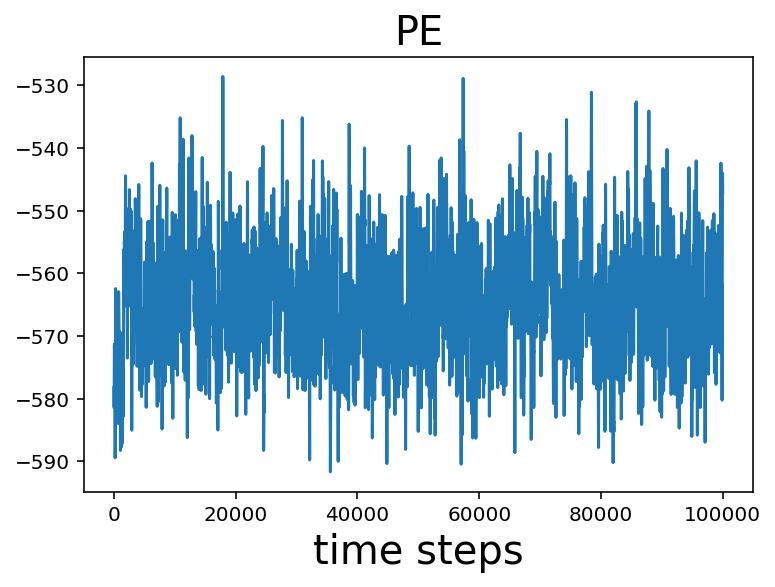

In [376]:
plt.plot(data[0])
plt.title('PE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

Text(0.5, 0, 'time steps')

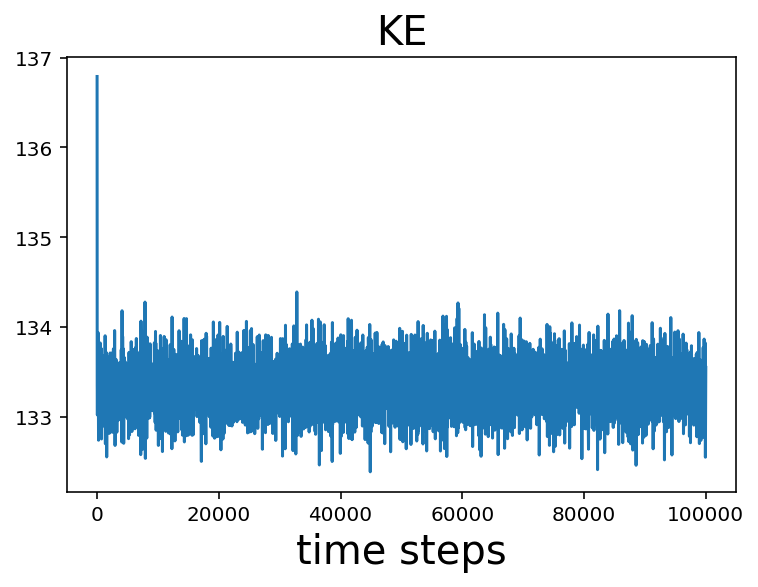

In [377]:
plt.plot(data[1])
plt.title('KE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

Text(0.5, 0, 'time steps')

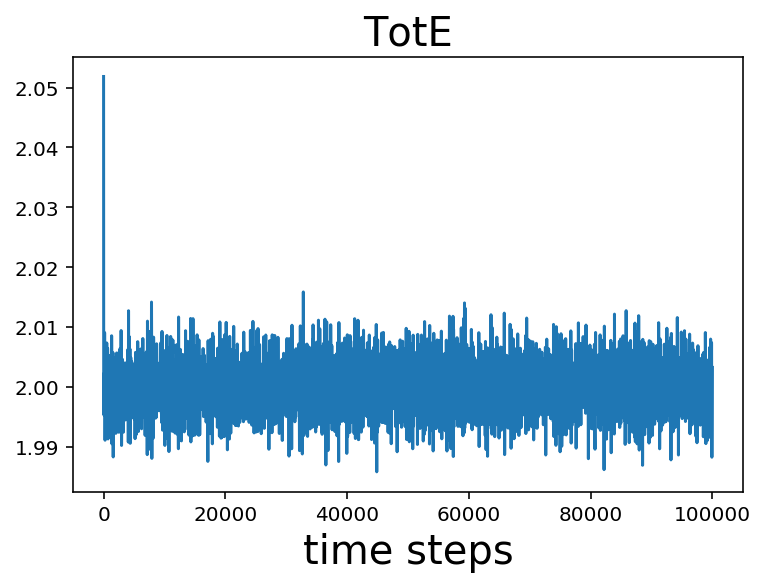

In [378]:
plt.plot(data[2])
plt.title('TotE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

### Compute $g(r)$

In [386]:
@jit
def get_dists(particles, L):
    
    '''Compute all pairwise  distances'''
    
    N   = len(particles)
    dr = [] 
    
    for i in range(0,N-1):
        for j in range(i+1,N):
            
            dr.append(get_dr(particles[i],particles[j], L) )

    return np.abs(dr)

In [387]:
@jit
def comp_g_r(particles, L):
    '''Computing radial distirbution function for a single configuration'''
    
    # Number of particles and density
    N   = len(particles)
    rho = N/(L**3)
    
    #Get dists
    r_dists = get_dists(particles, L)
    
    #Histogram distances 
    histRadii, edges = np.histogram(r_dists, bins=40, range=(0,L/2))
    radii = 0.5 *(edges[1:] + edges[:-1])  
    
    # If we loop over N*N pairs then divide by N 
    # We have N*(N-1)/2 pairs and divide by (N-1)/2 to have hist for N particles
    histRadii = histRadii/(0.5*(N-1))    
    
    #Compute histogram that would be displayed by an ideal gas of N particles 
    vol       = (4.0/3.0) * np.pi * (edges[1:]**3 - edges[:-1]**3)
    
    histIdeal = rho * vol 
    
    gr = histRadii/histIdeal 
    
    return radii, gr

In [391]:
n_pt = 100
confs = data[4]

In [396]:
gr_t = 0

av_wind = n_pt//2

for i in range(n_pt-av_wind, n_pt):
    
    radii, gr = comp_g_r(confs[i],L)
    
    gr_t += gr/av_wind

In [398]:
#plt.plot(radii, gr_t, '-o')
#plt.grid(True)